In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    _mapa = {
        "B": "#Bearer",
        "T": "TimeStamp",
        "TX": "Transmission",
        "RX": "Receiver",
        "D": "Delay",
        "ID": "#Packet",
        "DST": "Destiny",
        "SRC": "Source",
        "SIZE": "Size"
    }
    @staticmethod
    def parse(inFile, flowDuration = 100):
        #VIDEO
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        videoPLR = []
        #VOICE
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        voicePLR = []
        #WEB
        WebAverages = []
        WebFairness = []
        WebDelay = []
        WebJitter = []
        WebPLR = []
        #CBR
        CBRAverages = []
        CBRFairness = []
        CBRDelay = []
        CBRJitter = []
        CBRPLR = []
        #GERAL
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            #VIDEO
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            videoPLR.append(packetLossInfo[1]['VIDEO'])
            #VOICE
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            voicePLR.append(packetLossInfo[1]['VOIP'])
            #WEBBUF
            WebAverages.append(info['WEB']['Average'])
            WebFairness.append(info['WEB']['FairnessIndex'])
            WebDelay.append(delayInfo['WEB']['Average'])
            WebJitter.append(delayInfo['WEB']['StD'])
            WebPLR.append(packetLossInfo[1]['WEB'])
            #CBRBUF
            CBRAverages.append(info['CBR']['Average'])
            CBRFairness.append(info['CBR']['FairnessIndex'])
            CBRDelay.append(delayInfo['CBR']['Average'])
            CBRJitter.append(delayInfo['CBR']['StD'])
            CBRPLR.append(packetLossInfo[1]['CBR'])
            #GERAL
            packetLoss.append(packetLossInfo[0])
        return [#VIDEO
                (sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(videoPLR)/len(videoPLR)),
                #VOICE
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(voiceDelay)/len(voiceDelay)),
                (sum(voiceJitter)/len(voiceJitter)),
                (sum(voicePLR)/len(voicePLR)),
                #WEB
                (sum(WebAverages)/len(WebAverages)),
                (sum(WebFairness)/len(WebFairness)),
                (sum(WebDelay)/len(WebDelay)),
                (sum(WebJitter)/len(WebJitter)),
                (sum(WebPLR)/len(WebPLR)),
                #CBR
                (sum(CBRAverages)/len(CBRAverages)),
                (sum(CBRFairness)/len(CBRFairness)),
                (sum(CBRDelay)/len(CBRDelay)),
                (sum(CBRJitter)/len(CBRJitter)),
                (sum(CBRPLR)/len(CBRPLR)),
                #GERAL
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        matches = re.findall(r"(^TX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        matches = re.findall(r"(^RX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for RX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            keytx = len(txContent[key])
            tx_pkts += keytx
            keyrx = len(rxContent[key])
            rx_pkts += keyrx
            keyPLR = ((keytx - keyrx) / (keytx if keytx != 0 else 1)) * 100
            dictPacketType[key] = keyPLR
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr, dictPacketType
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = (delayPerApp[app]["Sum"]/tamanho) if tamanho != 0 else 0
            delayPerApp[app]["StD"] = (sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1)) if tamanho-1 != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"])/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"])/flowDuration
        return tputPerApp
    
    @staticmethod
    def getSpectralEff():
        pass
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"])/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [2]:
base = "../../../../Simulations/SingleCell/FLSPass/P50_50"
graphicsbase = "../pdfs/FLSPass/P50_50/"
ext = ".gz"
until = 21
users = 51
scheds = 9
files = {
         1: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         2: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         3: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         4: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         5: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         6: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         7: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
        8: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             }
        }
for sched in range(1,scheds):
    for ue in range(10, users, 10):
        for count in range(1,until):
            file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_" + str(count)
            filename = base + file + ext
            files[sched][3][ue].append(filename)

In [3]:
metrics = {
    "VIDEO":{
        "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "VOICE":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "WEB":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "CBR":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "GERAL": {
      "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    }
}
for sched in range(1, 9):
    for ue in range(10, users, 10):
        info = LTEParser.parse(files[sched][3][ue], 100)
        #VIDEO
        metrics["VIDEO"]["GPUTS"][sched].append(info[0])
        metrics["VIDEO"]["FAIR"][sched].append(info[1])
        metrics["VIDEO"]["DELAY"][sched].append(info[2])
        metrics["VIDEO"]["JITTER"][sched].append(info[3])
        metrics["VIDEO"]["PLR"][sched].append(info[4])
        #VOICE
        metrics["VOICE"]["GPUTS"][sched].append(info[5])
        metrics["VOICE"]["FAIR"][sched].append(info[6])
        metrics["VOICE"]["DELAY"][sched].append(info[7])
        metrics["VOICE"]["JITTER"][sched].append(info[8])
        metrics["VOICE"]["PLR"][sched].append(info[9])
        #WEB
        metrics["WEB"]["GPUTS"][sched].append(info[10])
        metrics["WEB"]["FAIR"][sched].append(info[11])
        metrics["WEB"]["DELAY"][sched].append(info[12])
        metrics["WEB"]["JITTER"][sched].append(info[13])
        metrics["WEB"]["PLR"][sched].append(info[14])
        #CBR
        metrics["CBR"]["GPUTS"][sched].append(info[15])
        metrics["CBR"]["FAIR"][sched].append(info[16])
        metrics["CBR"]["DELAY"][sched].append(info[17])
        metrics["CBR"]["JITTER"][sched].append(info[18])
        metrics["CBR"]["PLR"][sched].append(info[19])
        #GERAL
        metrics["GERAL"]["PLR"][sched].append(info[20])
    #VIDEO
for app in metrics:
    for metric in metrics[app]:
        for sched in metrics[app][metric]:
            metrics[app][metric][sched] = np.array(metrics[app][metric][sched], dtype=np.float32)

Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_2.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_3.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_4.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_5.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_6.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_7.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_8.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_10_9.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_40_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_2.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_3.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_4.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_5.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_6.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_7.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_1_UE_50_8.gz
Parsing file ...Done
Opening file: ../../../../Simulations/Sing

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_30_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_30_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_40_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_40_2.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_40_3.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_40_4.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_40_5.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_40_6.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_2_UE_40_7.gz
Parsing file ...Done
Opening file: ../../../../Simulations/Sin

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_20_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_20_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_20_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_30_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_30_2.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_30_3.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_30_4.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_30_5.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_3_UE_30_6.gz
Parsing file ...Done
Opening file: ../../../../Simulations/Si

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_10_17.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_10_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_10_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_10_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_20_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_20_2.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_20_3.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_20_4.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_20_5.gz
Parsing file ...Done
Opening file: ../../../../Simulations/S

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_50_16.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_50_17.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_50_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_50_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_4_UE_50_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_10_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_10_2.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_10_3.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_10_4.gz
Parsing file ...Done
Opening file: ../../../../Simulations/

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_40_15.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_40_16.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_40_17.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_40_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_40_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_40_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_50_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_50_2.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_5_UE_50_3.gz
Parsing file ...Done
Opening file: ../../../../Simulations

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_30_14.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_30_15.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_30_16.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_30_17.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_30_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_30_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_30_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_40_1.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_6_UE_40_2.gz
Parsing file ...Done
Opening file: ../../../../Simulation

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_13.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_14.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_15.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_16.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_17.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_20_20.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_7_UE_30_1.gz
Parsing file ...Done
Opening file: ../../../../Simulatio

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_12.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_13.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_14.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_15.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_16.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_17.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_19.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_10_20.gz
Parsing file ...Done
Opening file: ../../../../Simulati

Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_11.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_12.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_13.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_14.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_15.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_16.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_17.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_18.gz
Parsing file ...Done
Opening file: ../../../../Simulations/SingleCell/FLSPass/P50_50/SCHED_8_UE_50_19.gz
Parsing file ...Done
Opening file: ../../../../Simulati

# VIDEO
## GPUT

In [4]:
MEGAVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics["VIDEO"]["GPUTS"]:
    MEGAVIDEO[sched] = np.true_divide(metrics["VIDEO"]["GPUTS"][sched], 1e+6)

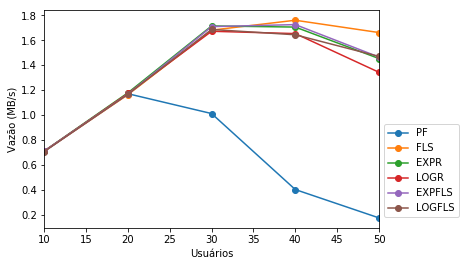

In [21]:
dfGPUTVIDEO = pd.DataFrame({'PF': MEGAVIDEO[1],
                       'FLS': MEGAVIDEO[4], 'EXPR': MEGAVIDEO[5], 'LOGR': MEGAVIDEO[6],
                        'EXPFLS': MEGAVIDEO[7], 'LOGFLS': MEGAVIDEO[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTVIDEO.plot(rot=0, marker='o')
plot.set(xlabel="Usuários", ylabel="Vazão (MB/s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "GPUTVideo.pdf", bbox_inches='tight')

In [6]:
dfGPUTVIDEO

,PF,FLS,EXPR,LOGR,EXPFLS,LOGFLS
10,0.709593,0.709433,0.710673,0.710225,0.709482,0.706738
20,1.170717,1.163066,1.178065,1.172484,1.167438,1.166448
30,1.011577,1.680526,1.714381,1.671516,1.708868,1.685970
40,0.402051,1.760010,1.705237,1.652937,1.724987,1.643469
50,0.174575,1.661255,1.452653,1.342435,1.464616,1.469781


## Delay

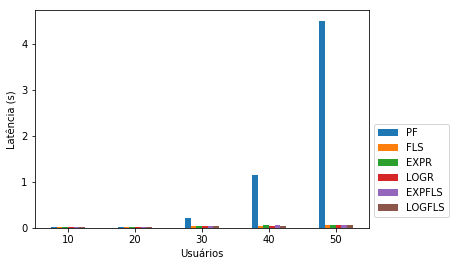

In [20]:
dfDELAYVIDEO = pd.DataFrame({'PF': metrics["VIDEO"]["DELAY"][1],
                            'FLS': metrics["VIDEO"]["DELAY"][4], 'EXPR': metrics["VIDEO"]["DELAY"][5],
                             'LOGR': metrics["VIDEO"]["DELAY"][6], 'EXPFLS': metrics["VIDEO"]["DELAY"][7]
                            ,'LOGFLS': metrics["VIDEO"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase +"DelayVideoPF.pdf", bbox_inches='tight')

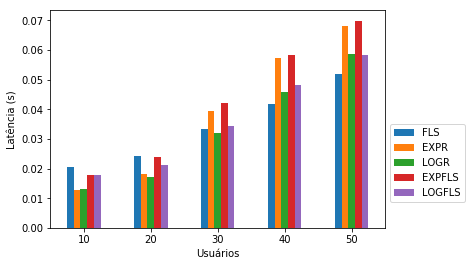

In [19]:
dfDELAYVIDEO = pd.DataFrame({'FLS': metrics["VIDEO"]["DELAY"][4], 'EXPR': metrics["VIDEO"]["DELAY"][5],
                             'LOGR': metrics["VIDEO"]["DELAY"][6], 'EXPFLS': metrics["VIDEO"]["DELAY"][7],
                            'LOGFLS': metrics["VIDEO"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "DelayVideo.pdf", bbox_inches='tight')

## JITTER

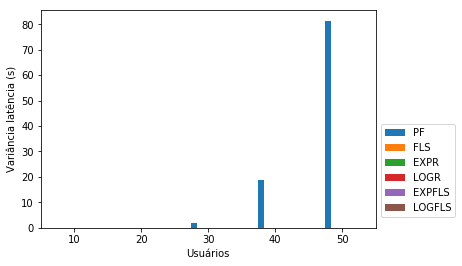

In [22]:
dfJITTERVIDEO = pd.DataFrame({'PF': metrics["VIDEO"]["JITTER"][1],'FLS': metrics["VIDEO"]["JITTER"][4],
                              'EXPR': metrics["VIDEO"]["JITTER"][5], 'LOGR': metrics["VIDEO"]["JITTER"][6],
                              'EXPFLS': metrics["VIDEO"]["JITTER"][7],'LOGFLS': metrics["VIDEO"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Variância latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "JitterVideoPF.pdf", bbox_inches='tight')

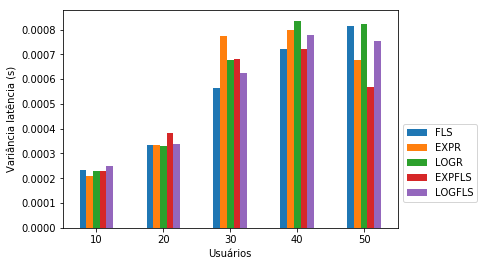

In [23]:
dfJITTERVIDEO = pd.DataFrame({'FLS': metrics["VIDEO"]["JITTER"][4], 'EXPR': metrics["VIDEO"]["JITTER"][5],
                            'LOGR': metrics["VIDEO"]["JITTER"][6], 'EXPFLS': metrics["VIDEO"]["JITTER"][7],
                             'LOGFLS': metrics["VIDEO"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Variância latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "JitterVideo.pdf", bbox_inches='tight')

## FAIRNESS

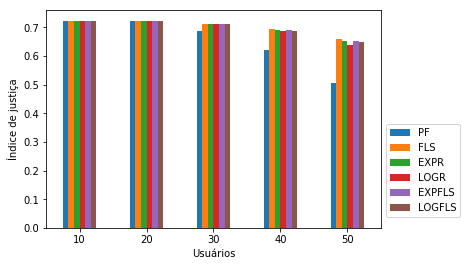

In [25]:
dfFAIRVIDEO = pd.DataFrame({'PF': metrics["VIDEO"]["FAIR"][1], 'FLS': metrics["VIDEO"]["FAIR"][4],
                            'EXPR': metrics["VIDEO"]["FAIR"][5], 'LOGR': metrics["VIDEO"]["FAIR"][6],
                            'EXPFLS': metrics["VIDEO"]["FAIR"][7], 'LOGFLS': metrics["VIDEO"]["FAIR"][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRVIDEO.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Índice de justiça")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "FairnessVideo.pdf", bbox_inches='tight')

## PLR

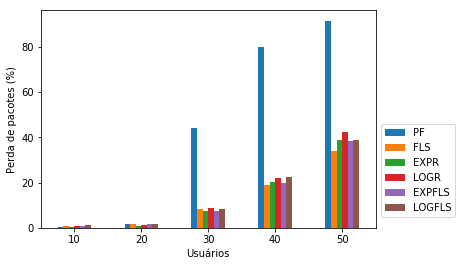

In [26]:
dfPLRVIDEO = pd.DataFrame({'PF': metrics["VIDEO"]["PLR"][1], 'FLS': metrics["VIDEO"]["PLR"][4],
                           'EXPR': metrics["VIDEO"]["PLR"][5], 'LOGR': metrics["VIDEO"]["PLR"][6],
                          'EXPFLS': metrics["VIDEO"]["PLR"][7], 'LOGFLS': metrics["VIDEO"]["PLR"][8]},
                           index=[10,20,30,40,50])
plot = dfPLRVIDEO.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Perda de pacotes (%)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossVideo.pdf", bbox_inches='tight')

# VOIP
## GPUT

In [27]:
MEGAVOIP = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics['VOICE']['GPUTS']:
    MEGAVOIP[sched] = np.true_divide(metrics['VOICE']['GPUTS'][sched], 1e+6)

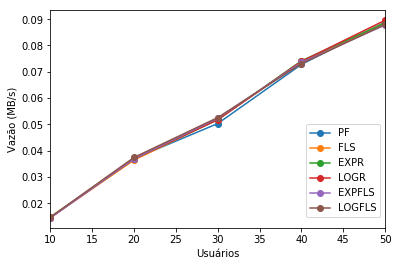

In [28]:
dfGPUTVOICE = pd.DataFrame({'PF': MEGAVOIP[1], 'FLS': MEGAVOIP[4],
                            'EXPR': MEGAVOIP[5], 'LOGR': MEGAVOIP[6],
                            'EXPFLS': MEGAVOIP[7], 'LOGFLS': MEGAVOIP[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTVOICE.plot(rot=0, marker='o')
plot.set(xlabel="Usuários", ylabel="Vazão (MB/s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "GPUTVoIP.pdf", bbox_inches='tight')

## Delay

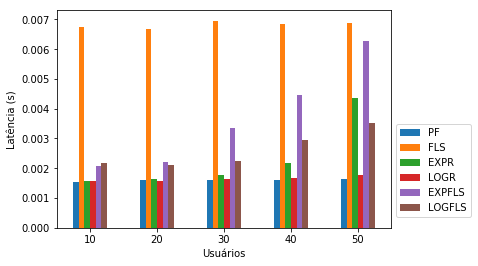

In [29]:
dfDELAYVOICE = pd.DataFrame({'PF': metrics['VOICE']['DELAY'][1], 'FLS': metrics['VOICE']['DELAY'][4],
                             'EXPR': metrics['VOICE']['DELAY'][5], 'LOGR': metrics['VOICE']['DELAY'][6],
                            'EXPFLS': metrics['VOICE']['DELAY'][7], 'LOGFLS': metrics['VOICE']['DELAY'][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYVOICE.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "DelayVoIPPF.pdf", bbox_inches='tight')

## Jitter

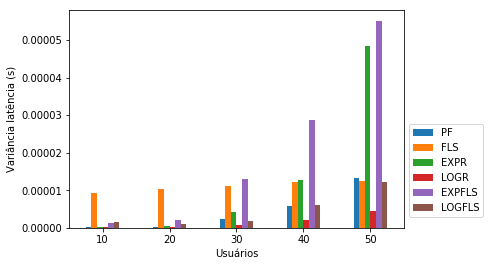

In [30]:
dfJITTERVOICE = pd.DataFrame({'PF': metrics['VOICE']['JITTER'][1], 'FLS': metrics['VOICE']['JITTER'][4],
                              'EXPR': metrics['VOICE']['JITTER'][5], 'LOGR': metrics['VOICE']['JITTER'][6],
                             'EXPFLS': metrics['VOICE']['JITTER'][7], 'LOGFLS': metrics['VOICE']['JITTER'][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERVOICE.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Variância latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "JitterVoIPPF.pdf", bbox_inches='tight')

## FAIRNESS

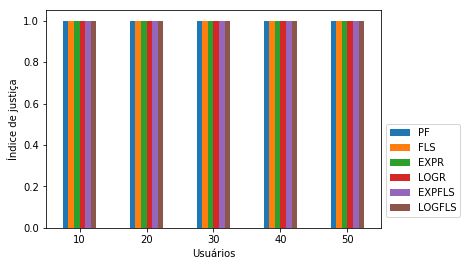

In [31]:
dfFAIRVOICE = pd.DataFrame({'PF': metrics['VOICE']['FAIR'][1], 'FLS': metrics['VOICE']['FAIR'][4],
                            'EXPR': metrics['VOICE']['FAIR'][5], 'LOGR': metrics['VOICE']['FAIR'][6],
                           'EXPFLS': metrics['VOICE']['FAIR'][7], 'LOGFLS': metrics['VOICE']['FAIR'][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRVOICE.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Índice de justiça")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "FairnessVoice.pdf", bbox_inches='tight')

## PLR

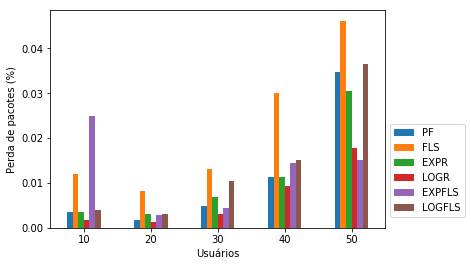

In [32]:
dfPLRVOICE = pd.DataFrame({'PF': metrics['VOICE']['PLR'][1], 'FLS': metrics['VOICE']['PLR'][4],
                           'EXPR': metrics['VOICE']['PLR'][5], 'LOGR': metrics['VOICE']['PLR'][6],
                          'EXPFLS': metrics['VOICE']['PLR'][7], 'LOGFLS': metrics['VOICE']['PLR'][8]},
                           index=[10,20,30,40,50])
plot = dfPLRVOICE.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Perda de pacotes (%)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossVoice.pdf", bbox_inches='tight')

# WEB
## GPUT

In [33]:
MEGAWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics["WEB"]["GPUTS"]:
    MEGAWEB[sched] = np.true_divide(metrics["WEB"]["GPUTS"][sched], 1e+6)

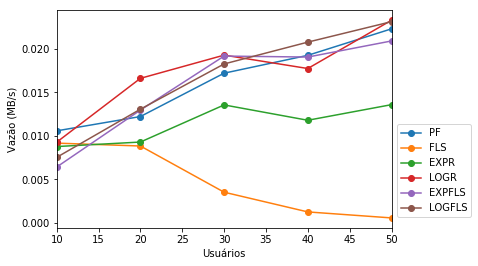

In [35]:
dfGPUTWEB = pd.DataFrame({'PF': MEGAWEB[1],
                       'FLS': MEGAWEB[4], 'EXPR': MEGAWEB[5], 'LOGR': MEGAWEB[6],
                        'EXPFLS': MEGAWEB[7], 'LOGFLS': MEGAWEB[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTWEB.plot(rot=0, marker='o')
plot.set(xlabel="Usuários", ylabel="Vazão (MB/s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "GPUTWeb.pdf", bbox_inches='tight')

## Delay

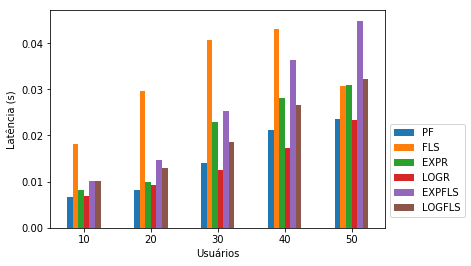

In [36]:
dfDELAYWEB = pd.DataFrame({'PF': metrics["WEB"]["DELAY"][1],
                            'FLS': metrics["WEB"]["DELAY"][4], 'EXPR': metrics["WEB"]["DELAY"][5], 'LOGR': metrics["WEB"]["DELAY"][6],
                             'EXPFLS': metrics["WEB"]["DELAY"][7], 'LOGFLS': metrics["WEB"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYWEB.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "DelayWeb.pdf", bbox_inches='tight')

## Jitter

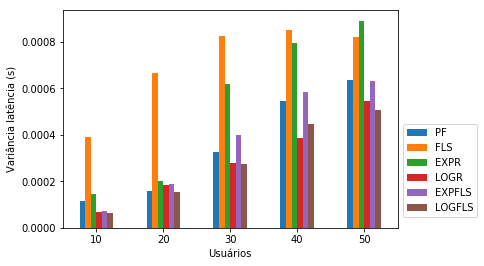

In [37]:
dfJITTERWEB = pd.DataFrame({'PF': metrics["WEB"]["JITTER"][1],
                            'FLS': metrics["WEB"]["JITTER"][4], 'EXPR': metrics["WEB"]["JITTER"][5], 'LOGR': metrics["WEB"]["JITTER"][6],
                            'EXPFLS': metrics["WEB"]["JITTER"][7], 'LOGFLS': metrics["WEB"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERWEB.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Variância latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "JitterWebPF.pdf", bbox_inches='tight')

## FAIRNESS

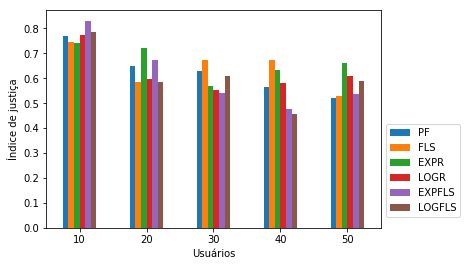

In [38]:
dfFAIRWEB = pd.DataFrame({'PF': metrics["WEB"]["FAIR"][1],
                            'FLS': metrics["WEB"]["FAIR"][4], 'EXPR': metrics["WEB"]["FAIR"][5], 'LOGR': metrics["WEB"]["FAIR"][6],
                            'EXPFLS': metrics["WEB"]["FAIR"][7], 'LOGFLS': metrics["WEB"]["FAIR"][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRWEB.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Índice de justiça")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "FairnessWeb.pdf", bbox_inches='tight')

## PLR

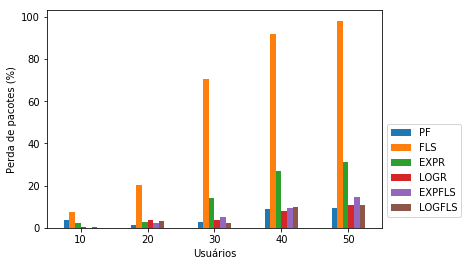

In [39]:
dfPLRWEB = pd.DataFrame({'PF': metrics["WEB"]["PLR"][1],
                            'FLS': metrics["WEB"]["PLR"][4], 'EXPR': metrics["WEB"]["PLR"][5], 'LOGR': metrics["WEB"]["PLR"][6],
                           'EXPFLS': metrics["WEB"]["PLR"][7], 'LOGFLS': metrics["WEB"]["PLR"][8]},
                           index=[10,20,30,40,50])
plot = dfPLRWEB.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Perda de pacotes (%)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossWeb.pdf", bbox_inches='tight')

# CBR
## GPUT

In [40]:
MEGACBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics["CBR"]["GPUTS"]:
    MEGACBR[sched] = np.true_divide(metrics["CBR"]["GPUTS"][sched], 1e+6)

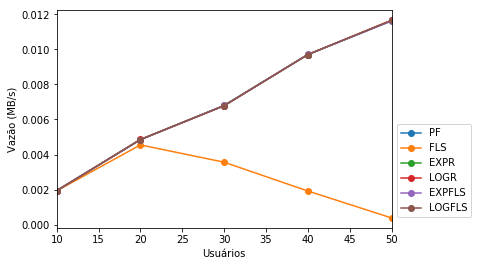

In [41]:
dfGPUTCBR = pd.DataFrame({'PF': MEGACBR[1],
                       'FLS': MEGACBR[4], 'EXPR': MEGACBR[5], 'LOGR': MEGACBR[6],
                        'EXPFLS': MEGACBR[7], 'LOGFLS': MEGACBR[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTCBR.plot(rot=0, marker='o')
plot.set(xlabel="Usuários", ylabel="Vazão (MB/s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "GPUTCBR.pdf", bbox_inches='tight')

## Delay

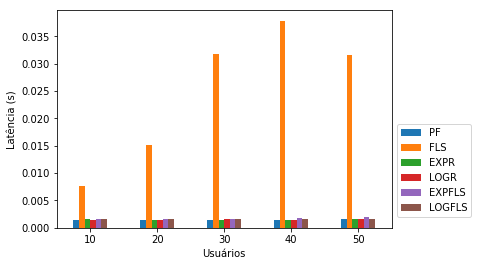

In [42]:
dfDELAYCBR = pd.DataFrame({'PF': metrics["CBR"]["DELAY"][1],
                            'FLS': metrics["CBR"]["DELAY"][4], 'EXPR': metrics["CBR"]["DELAY"][5], 'LOGR': metrics["CBR"]["DELAY"][6],
                             'EXPFLS': metrics["CBR"]["DELAY"][7], 'LOGFLS': metrics["CBR"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYCBR.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "DelayCBR.pdf", bbox_inches='tight')

## Jitter

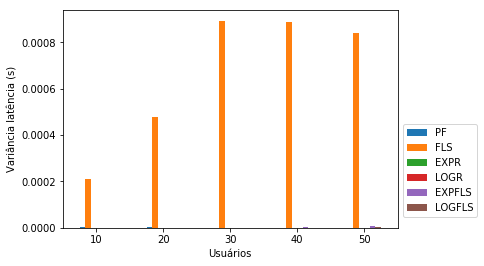

In [43]:
dfJITTERCBR = pd.DataFrame({'PF': metrics["CBR"]["JITTER"][1],
                            'FLS': metrics["CBR"]["JITTER"][4], 'EXPR': metrics["CBR"]["JITTER"][5], 'LOGR': metrics["CBR"]["JITTER"][6],
                            'EXPFLS': metrics["CBR"]["JITTER"][7], 'LOGFLS': metrics["CBR"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERCBR.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Variância latência (s)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "JitterCBRPF.pdf", bbox_inches='tight')

## FAIRNESS

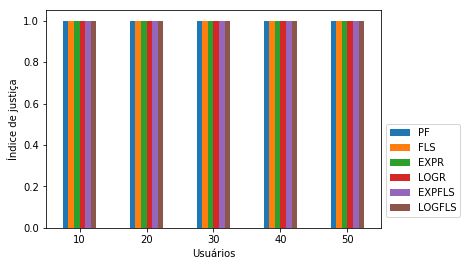

In [44]:
dfFAIRCBR = pd.DataFrame({'PF': metrics["CBR"]["FAIR"][1], 
                            'FLS': metrics["CBR"]["FAIR"][4], 'EXPR': metrics["CBR"]["FAIR"][5], 'LOGR': metrics["CBR"]["FAIR"][6],
                            'EXPFLS': metrics["CBR"]["FAIR"][7], 'LOGFLS': metrics["CBR"]["FAIR"][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRCBR.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Índice de justiça")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "FairnessCBR.pdf", bbox_inches='tight')

## PLR

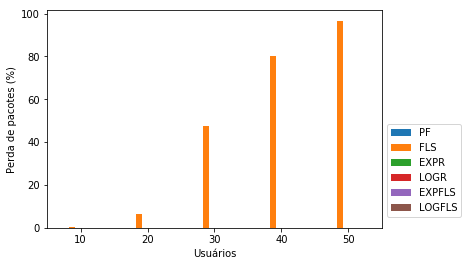

In [45]:
dfPLRCBR = pd.DataFrame({'PF': metrics["CBR"]["PLR"][1],
                            'FLS': metrics["CBR"]["PLR"][4], 'EXPR': metrics["CBR"]["PLR"][5], 'LOGR': metrics["CBR"]["PLR"][6],
                           'EXPFLS': metrics["CBR"]["PLR"][7], 'LOGFLS': metrics["CBR"]["PLR"][8]},
                           index=[10,20,30,40,50])
plot = dfPLRCBR.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Perda de pacotes (%)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossCBR.pdf", bbox_inches='tight')

# Loss Ratio

In [46]:
averagePacketLoss = {}
for key in metrics["GERAL"]["PLR"]:
    averagePacketLoss[key] = []
    for i in range(0, 5):
        average = sum(metrics["GERAL"]["PLR"][key][i])/len(metrics["GERAL"]["PLR"][key][i])
        averagePacketLoss[key].append(average)

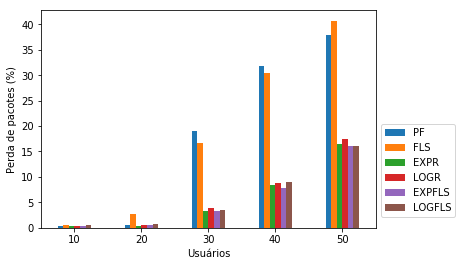

In [47]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6],
                           'EXPFLS': averagePacketLoss[7], 'LOGFLS': averagePacketLoss[8]},
                           index=[10,20,30,40,50])
plot = dfLossRatio.plot.bar(rot=0)
plot.set(xlabel="Usuários", ylabel="Perda de pacotes (%)")
plot.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossRatio.pdf", bbox_inches='tight')